# OWASP Benchmark SAST Tool Analysis
## Scorecard Metrics Extraction and Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import glob
import os
import json
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Data Extraction Functions

In [2]:
def parse_tool_scorecard(html_file):
    """
    Parse individual tool scorecard HTML to extract metrics.
    Returns DataFrame with vulnerability-specific metrics for the tool.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract tool name from title or heading
    title = soup.find('h3')
    if title:
        tool_name = title.text.replace('OWASP Benchmark Scorecard for ', '').replace(' (SAST)', '').strip()
    else:
        tool_name = Path(html_file).stem
    
    # find results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        # check if this is the detailed results table
        if 'Category' in headers and 'CWE #' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]: # skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9: # ensure data
                    if cells[0] not in ['Totals', 'Overall Results*']:
                        rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Category', 'CWE', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Tool'] = tool_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                #convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_vulnerability_scorecard(html_file):
    """
    Parse vulnerability-specific scorecard to extract all tools' performance on that vulnerability.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract vulnerability name
    title = soup.find('h3')
    if title:
        vuln_name = title.text.replace('OWASP Benchmark Scorecard for ', '').strip()
    else:
        vuln_name = Path(html_file).stem
    
    # find the detailed results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]: # skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Vulnerability'] = vuln_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_summary_scorecard(html_file):
    """
    Parse the summary scorecard to get overall tool scores.
    """
    
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # find summary table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers and 'Score*' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]:  # Skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 4:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TPR', 'FPR', 'Score'])
                
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

## Load All Scorecard Data

In [3]:
scorecard_dir = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard'
to_save = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard/outputs/'
os.makedirs(to_save, exist_ok=True)

In [4]:
# find all scorecard HTML files
tool_scorecards = glob.glob(os.path.join(scorecard_dir, '*CodeQL*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Semgrep*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Snyk*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SonarQube*.html'))

vuln_scorecards = glob.glob(os.path.join(scorecard_dir, '*Command_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SQL_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XSS*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Path_Traversal*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*LDAP*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Weak_*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Insecure_Cookie*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Trust_Boundary*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XPath*.html'))

summary_file = os.path.join(scorecard_dir, 'Scorecard_Home.html')

print(f"Found {len(tool_scorecards)} tool-specific scorecards")
print(f"Found {len(vuln_scorecards)} vulnerability-specific scorecards")
print(f"Summary file exists: {os.path.exists(summary_file)}")

Found 4 tool-specific scorecards
Found 11 vulnerability-specific scorecards
Summary file exists: True


In [5]:
# parse all tool scorecards
tool_data = []
for file in tool_scorecards:
    df = parse_tool_scorecard(file)
    if df is not None:
        tool_data.append(df)

if tool_data:
    df_tools = pd.concat(tool_data, ignore_index=True)
    print(f"Loaded data for {df_tools['Tool'].nunique()} tools across {df_tools['Category'].nunique()} vulnerability categories")
    print(f"Total records: {len(df_tools)}")
else:
    print("No tool data loaded")

Loaded data for 4 tools across 11 vulnerability categories
Total records: 44


In [6]:
# parse all vulnerability scorecards
vuln_data = []
for file in vuln_scorecards:
    df = parse_vulnerability_scorecard(file)
    if df is not None:
        vuln_data.append(df)

if vuln_data:
    df_vulns = pd.concat(vuln_data, ignore_index=True)
    print(f"Loaded vulnerability data for {df_vulns['Vulnerability'].nunique()} vulnerabilities")
else:
    print("No vulnerability data loaded")

Loaded vulnerability data for 11 vulnerabilities


In [7]:
# parse summary
if os.path.exists(summary_file):
    df_summary = parse_summary_scorecard(summary_file)
    if df_summary is not None:
        print(f"Loaded summary data for {len(df_summary)} tools")
        display(df_summary)
else:
    print("Summary file not found")

Loaded summary data for 4 tools


,Tool,Type,TPR,FPR,Score
0,CodeQL v2.23.6_w1.10.0rules,SAST,100.00,37.99,62.01
1,Semgrep v1.143.1,SAST,82.58,47.48,35.10
2,SnykCode v1.1301.0,SAST,97.18,25.16,72.02
3,SonarQube,SAST,9.09,2.12,6.97


## Load Results from Other Tools

In [8]:
def load_framework_results(json_file, tool_name):
    """
    Load analysis results from our framework's JSON format and convert to scorecard format.
    """
    
    # Category mapping from abbreviated names to full scorecard names
    category_map = {
        'cmdi': ('Command Injection', '78'),
        'crypto': ('Weak Encryption Algorithm', '327'),
        'hash': ('Weak Hashing Algorithm', '328'),
        'ldapi': ('LDAP Injection', '90'),
        'pathtraver': ('Path Traversal', '22'),
        'securecookie': ('Insecure Cookie', '614'),
        'sqli': ('SQL Injection', '89'),
        'trustbound': ('Trust Boundary', '501'),
        'weakrand': ('Weak Randomness', '330'),
        'xpathi': ('XPath Injection', '643'),
        'xss': ('XSS (Cross-Site Scripting)', '79')
    }
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    rows = []
    
    for short_name, metrics in data['by_category'].items():
        if short_name not in category_map:
            continue

        category_name, cwe = category_map[short_name]

        # Extract metrics
        total = metrics['total_tests']
        expected = metrics['vulnerable_tests']
        non_category_cases = metrics['safe_tests']
        tp = metrics['tp']
        fp = metrics['fp']
        fn = metrics['fn']
        tn = metrics['tn']

        # Calculate rates
        tpr = (tp / expected * 100) if expected > 0 else 0.0
        fpr = (fp / non_category_cases * 100) if non_category_cases > 0 else 0.0
        score = tpr - fpr

        rows.append({
            'Category': category_name,
            'CWE': cwe,
            'TP': tp,
            'FN': fn,
            'TN': tn,
            'FP': fp,
            'Total': total,
            'TPR': round(tpr, 2),
            'FPR': round(fpr, 2),
            'Score': round(score, 2),
            'Tool': tool_name
        })

    return pd.DataFrame(rows)

In [9]:
qwiet_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/qwiet_analysis.json'
corgea_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/corgea_analysis.json'

In [10]:
additional_tools = []

In [11]:
# Load Qwiet
if os.path.exists(qwiet_file):
    df_qwiet = load_framework_results(qwiet_file, 'Qwiet')
    additional_tools.append(df_qwiet)
    print(f"Loaded Qwiet data: {len(df_qwiet)} vulnerability categories")
else:
    print(f"Qwiet file not found: {qwiet_file}")

Loaded Qwiet data: 4 vulnerability categories


In [12]:
# Load Corgea
if os.path.exists(corgea_file):
    df_corgea = load_framework_results(corgea_file, 'Corgea')
    additional_tools.append(df_corgea)
    print(f"Loaded Corgea data: {len(df_corgea)} vulnerability categories")
else:
    print(f"Corgea file not found: {corgea_file}")

Loaded Corgea data: 11 vulnerability categories


In [13]:
# Merge with existing tool data
if additional_tools and 'df_tools' in locals():
    df_tools_original = df_tools.copy()
    df_tools = pd.concat([df_tools_original] + additional_tools, ignore_index=True)
    print(f"\n Combined dataset now includes {df_tools['Tool'].nunique()} tools")
    print(f"  Tools: {', '.join(df_tools['Tool'].unique())}")
elif additional_tools:
    df_tools = pd.concat(additional_tools, ignore_index=True)
    print(f"\n Created dataset with {df_tools['Tool'].nunique()} tools from framework")


 Combined dataset now includes 6 tools
  Tools: CodeQL v2.23.6_w1.10.0rules, Semgrep v1.143.1, SnykCode v1.1301.0, SonarQube, Qwiet, Corgea


In [14]:
if df_tools is not None:
    # Calculate overall metrics for all tools
    tool_summary = []
    
    for tool in df_tools['Tool'].unique():
        tool_data = df_tools[df_tools['Tool'] == tool]
        
        # Calculate weighted averages
        total_expected = tool_data['Total'].sum()
        total_tp = tool_data['TP'].sum()
        total_fp = tool_data['FP'].sum()
        total_fn = tool_data['FN'].sum()
        total_tn = tool_data['TN'].sum()
        
        total_vulnerable = total_tp + total_fn
        total_non_vulnerable = total_tn + total_fp

        # Calculate overall TPR and FPR
        overall_tpr = (total_tp / total_vulnerable * 100) if total_vulnerable > 0 else 0
        overall_fpr = (total_fp / total_non_vulnerable * 100) if total_non_vulnerable > 0 else 0
        
        overall_score = overall_tpr - overall_fpr

        tool_summary.append({
            'Tool': tool,
            'TPR': round(overall_tpr, 2),
            'FPR': round(overall_fpr, 2),
            'Score': round(overall_score, 2)
        })
    
    # Create updated summary
    df_summary = pd.DataFrame(tool_summary)
    display(df_summary.sort_values('Score', ascending=False))

,Tool,TPR,FPR,Score
2,SnykCode v1.1301.0,97.17,21.89,75.29
0,CodeQL v2.23.6_w1.10.0rules,100.00,40.08,59.92
4,Qwiet,96.60,42.53,54.07
1,Semgrep v1.143.1,74.42,41.66,32.76
5,Corgea,37.64,29.38,8.25
3,SonarQube,9.19,2.04,7.15


## Data Overview and Statistics

In [15]:
print("### Tool-Specific Data Overview ###")
display(df_tools.head(15))

print("\nTools analyzed:")
print(df_tools['Tool'].unique())

print("\nVulnerability categories:")
print(df_tools['Category'].unique())

### Tool-Specific Data Overview ###


,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool
0,Command Injection,78,126,0,61,64,251,100.00,51.20,48.80,CodeQL v2.23.6_w1.10.0rules
1,Insecure Cookie,614,36,0,31,0,67,100.00,0.00,100.00,CodeQL v2.23.6_w1.10.0rules
2,LDAP Injection,90,27,0,19,13,59,100.00,40.62,59.38,CodeQL v2.23.6_w1.10.0rules
3,Path Traversal,22,133,0,69,66,268,100.00,48.89,51.11,CodeQL v2.23.6_w1.10.0rules
4,SQL Injection,89,272,0,25,207,504,100.00,89.22,10.78,CodeQL v2.23.6_w1.10.0rules
5,Trust Boundary,501,83,0,19,24,126,100.00,55.81,44.19,CodeQL v2.23.6_w1.10.0rules
6,Weak Encryption Algorithm,327,130,0,89,27,246,100.00,23.28,76.72,CodeQL v2.23.6_w1.10.0rules
7,Weak Hashing Algorithm,328,129,0,74,33,236,100.00,30.84,69.16,CodeQL v2.23.6_w1.10.0rules
8,Weak Randomness,330,218,0,275,0,493,100.00,0.00,100.00,CodeQL v2.23.6_w1.10.0rules
9,XPath Injection,643,15,0,13,7,35,100.00,35.00,65.00,CodeQL v2.23.6_w1.10.0rules



Tools analyzed:
['CodeQL v2.23.6_w1.10.0rules' 'Semgrep v1.143.1' 'SnykCode v1.1301.0'
 'SonarQube' 'Qwiet' 'Corgea']

Vulnerability categories:
['Command Injection' 'Insecure Cookie' 'LDAP Injection' 'Path Traversal'
 'SQL Injection' 'Trust Boundary' 'Weak Encryption Algorithm'
 'Weak Hashing Algorithm' 'Weak Randomness' 'XPath Injection'
 'XSS (Cross-Site Scripting)']


In [16]:
df_tools[df_tools['Tool']=='Qwiet']

,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool
44,Command Injection,78,167,0,0,84,251,100.00,100.0,0.00,Qwiet
45,SQL Injection,89,334,20,150,0,504,94.35,0.0,94.35,Qwiet
46,LDAP Injection,90,42,0,0,17,59,100.00,100.0,0.00,Qwiet
47,XPath Injection,643,25,0,0,10,35,100.00,100.0,0.00,Qwiet


In [17]:
print("Statistical Summary by Tool")

summary_stats = df_tools.groupby('Tool').agg({
    'TPR': ['mean', 'std', 'min', 'max'],
    'FPR': ['mean', 'std', 'min', 'max'],
    'Score': ['mean', 'std', 'min', 'max'],
    'TP': 'sum',
    'FP': 'sum',
    'FN': 'sum',
    'TN': 'sum'
}).round(2)

display(summary_stats)

Statistical Summary by Tool


TPR                           FPR              \
                               mean    std     min     max   mean    std  min   
Tool                                                                            
CodeQL v2.23.6_w1.10.0rules  100.00   0.00  100.00  100.00  37.99  25.36  0.0   
Corgea                        34.53  23.20    0.00   62.15  35.05  22.78  0.0   
Qwiet                         98.59   2.83   94.35  100.00  75.00  50.00  0.0   
Semgrep v1.143.1              82.58  28.93    0.00  100.00  47.48  38.85  0.0   
SnykCode v1.1301.0            97.18   9.35   68.99  100.00  25.16  21.55  0.0   
SonarQube                      9.09  30.15    0.00  100.00   2.12   7.02  0.0   

                                     Score                          TP   FP  \
                                max   mean    std    min     max   sum  sum   
Tool                                                                          
CodeQL v2.23.6_w1.10.0rules   89.22  62.01  25.36  10.78  100.00  1415  531   
Corgea                        70.00  -0.53  13.02 -34.00   10.08   720  243   
Qwiet                        100.00  23.59  47.18   0.00   94.35   568  111   
Semgrep v1.143.1              87.50  35.10  36.74   0.00  100.00  1053  552   
SnykCode v1.1301.0            55.81  72.02  19.90  44.19  100.00  1375  290   
SonarQube                     23.28   6.97  23.13   0.00   76.72   130   27   

                               FN    TN  
                              sum   sum  
Tool                                     
CodeQL v2.23.6_w1.10.0rules     0   794  
Corgea                       1193   584  
Qwiet                          20   150  
Semgrep v1.143.1              362   773  
SnykCode v1.1301.0             40  1035  
SonarQube                    1285  1298

## Overall Performance Comparison

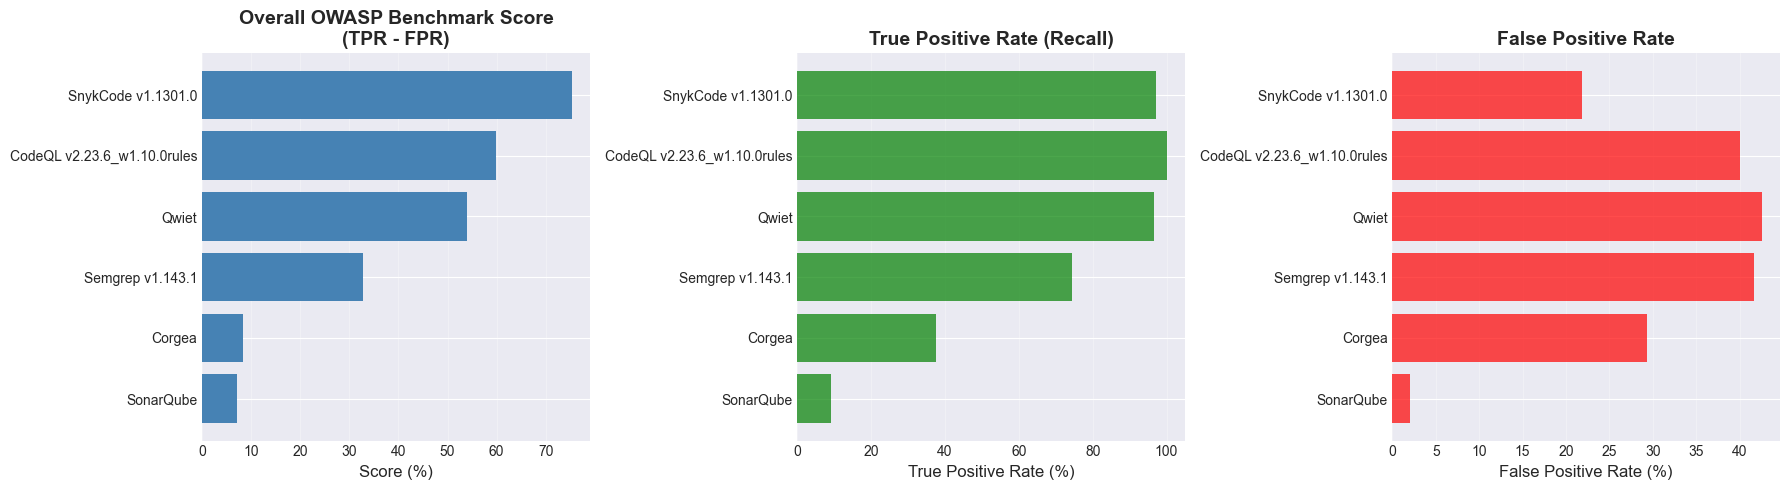

In [18]:
if 'df_summary' in locals() and df_summary is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # overall scores
    df_summary_sorted = df_summary.sort_values('Score', ascending=True)
    axes[0].barh(df_summary_sorted['Tool'], df_summary_sorted['Score'], color='steelblue')
    axes[0].set_xlabel('Score (%)', fontsize=12)
    axes[0].set_title('Overall OWASP Benchmark Score\n(TPR - FPR)', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # TPR comparison
    axes[1].barh(df_summary_sorted['Tool'], df_summary_sorted['TPR'], color='green', alpha=0.7)
    axes[1].set_xlabel('True Positive Rate (%)', fontsize=12)
    axes[1].set_title('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    # FPR comparison
    axes[2].barh(df_summary_sorted['Tool'], df_summary_sorted['FPR'], color='red', alpha=0.7)
    axes[2].set_xlabel('False Positive Rate (%)', fontsize=12)
    axes[2].set_title('False Positive Rate', fontsize=14, fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Performance Heatmap by Vulnerability Type

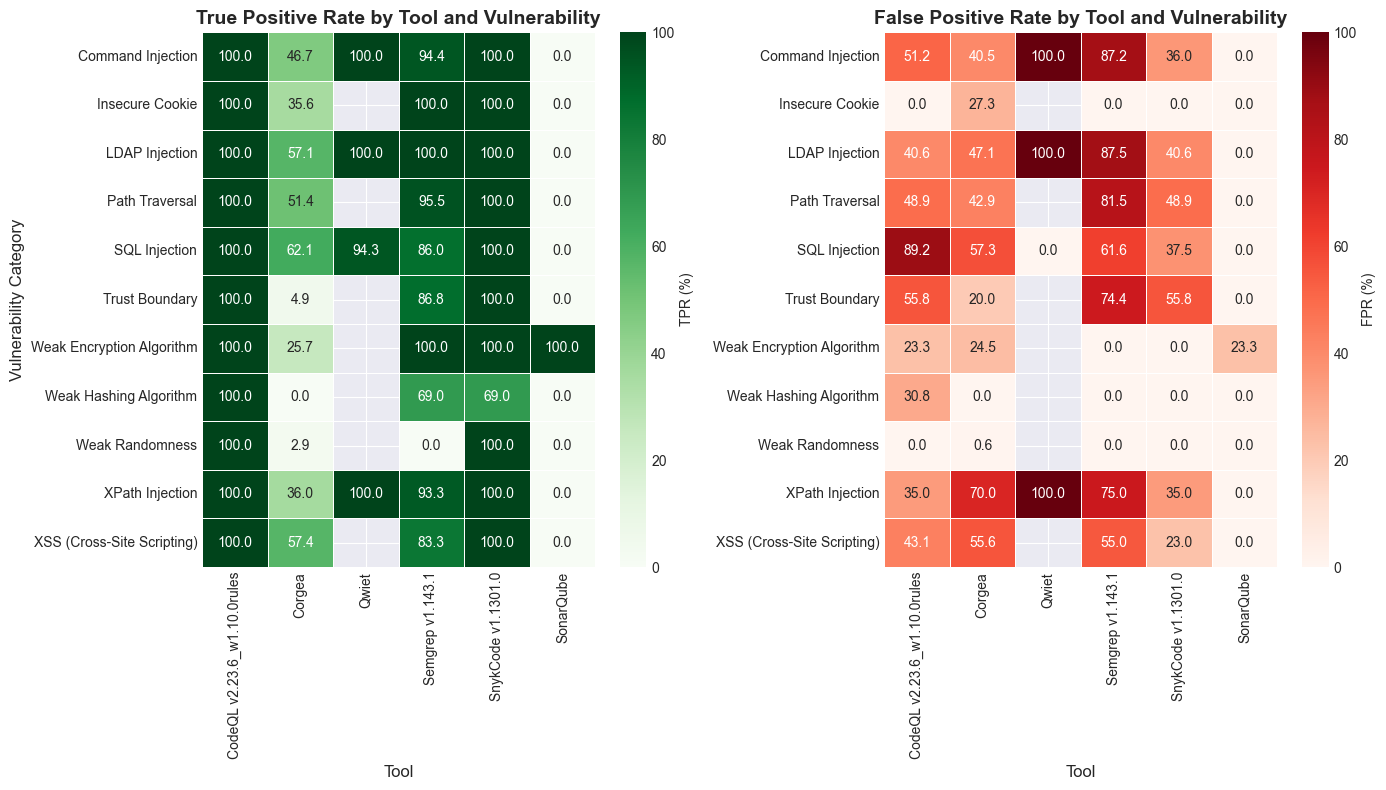

In [19]:
if 'df_tools' in locals():
    # pivot tables for heatmaps
    pivot_tpr = df_tools.pivot(index='Category', columns='Tool', values='TPR')
    pivot_fpr = df_tools.pivot(index='Category', columns='Tool', values='FPR')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    
    # TPR Heatmap
    sns.heatmap(pivot_tpr, annot=True, fmt='.1f', cmap='Greens', ax=axes[0], 
                cbar_kws={'label': 'TPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
    axes[0].set_title('True Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tool', fontsize=12)
    axes[0].set_ylabel('Vulnerability Category', fontsize=12)
    
    # FPR Heatmap
    sns.heatmap(pivot_fpr, annot=True, fmt='.1f', cmap='Reds', ax=axes[1], 
                cbar_kws={'label': 'FPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
    axes[1].set_title('False Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tool', fontsize=12)
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

## Score Heatmap

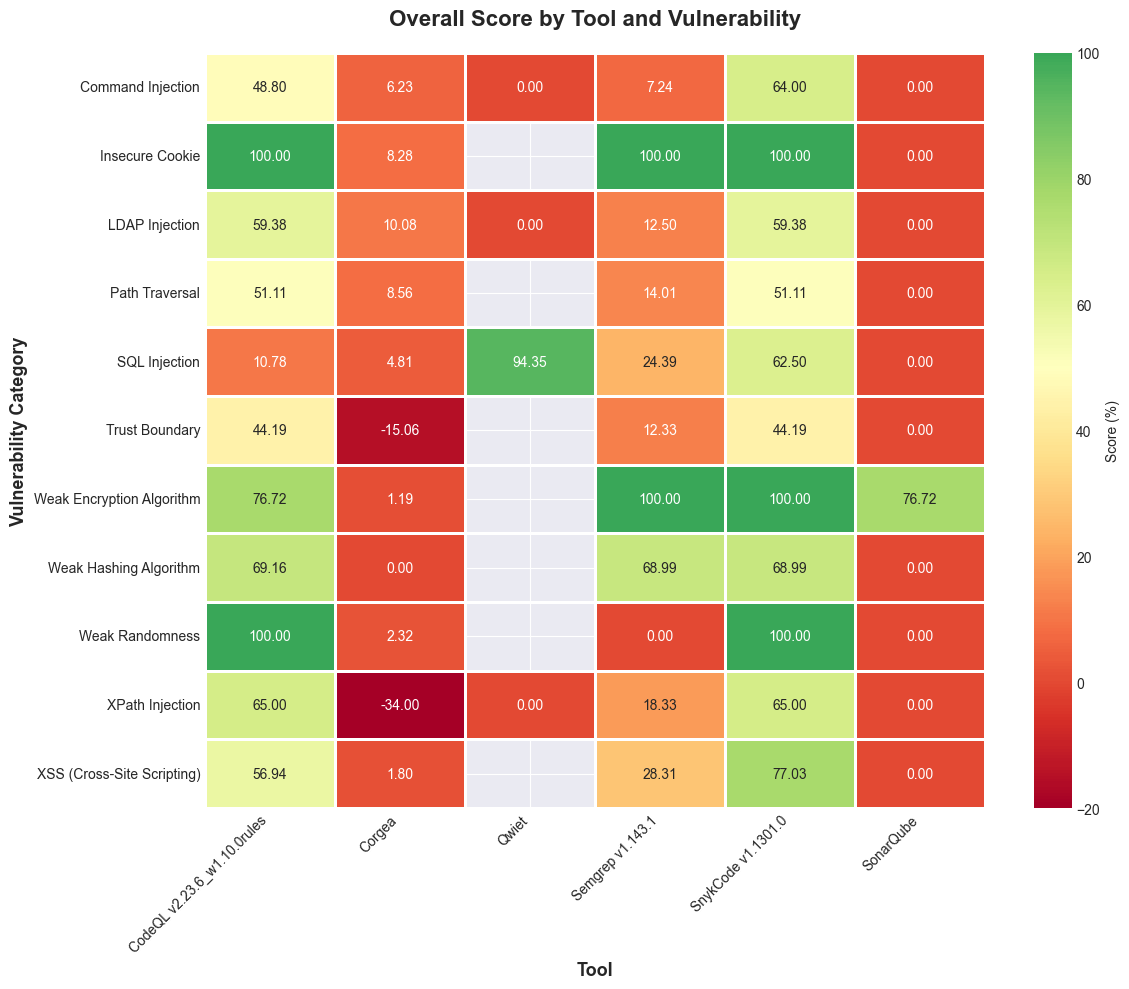

In [20]:
if 'df_tools' in locals():
    pivot_score = df_tools.pivot(index='Category', columns='Tool', values='Score')

    plt.figure(figsize=(12, 10))
    
    sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='RdYlGn', 
                cbar_kws={'label': 'Score (%)'},
                linewidths=1, linecolor='white',
                center=50, vmin=-20, vmax=100)
    
    plt.title('Overall Score by Tool and Vulnerability', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Tool', fontsize=13, fontweight='bold')
    plt.ylabel('Vulnerability Category', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

## Performance by Vulnerability Type

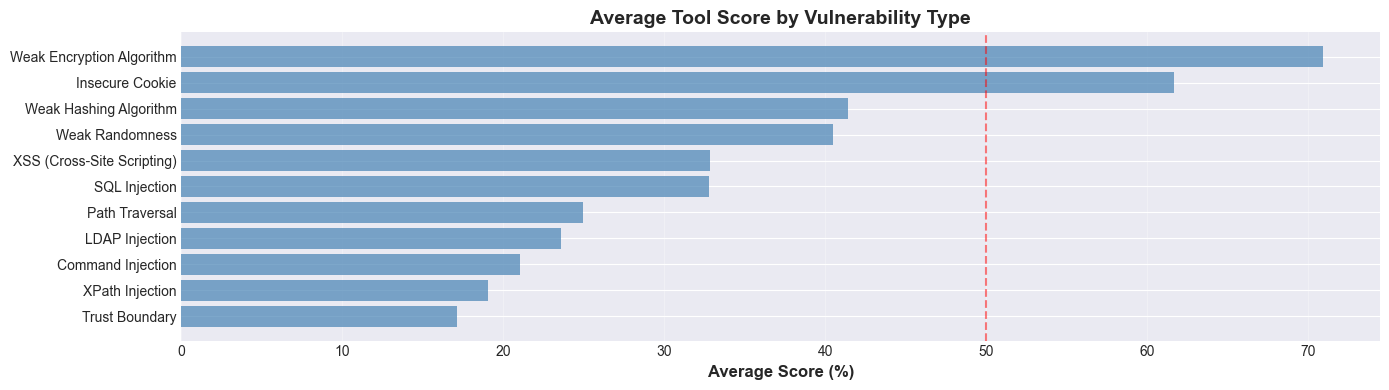

In [21]:
if 'df_tools' in locals():
    # calculate average performance per vulnerability
    vuln_avg = df_tools.groupby('Category')[['TPR', 'FPR', 'Score']].mean().sort_values('Score', ascending=True)
    
    fig, axes = plt.subplots(1, 1, figsize=(14,4))
    
    # score by vulnerability
    axes.barh(vuln_avg.index, vuln_avg['Score'], color='steelblue', alpha=0.7)
    axes.set_xlabel('Average Score (%)', fontsize=12, fontweight='bold')
    axes.set_title('Average Tool Score by Vulnerability Type', fontsize=14, fontweight='bold')
    axes.grid(axis='x', alpha=0.3)
    axes.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    
    plt.tight_layout()
    plt.show()

## Confusion Matrix

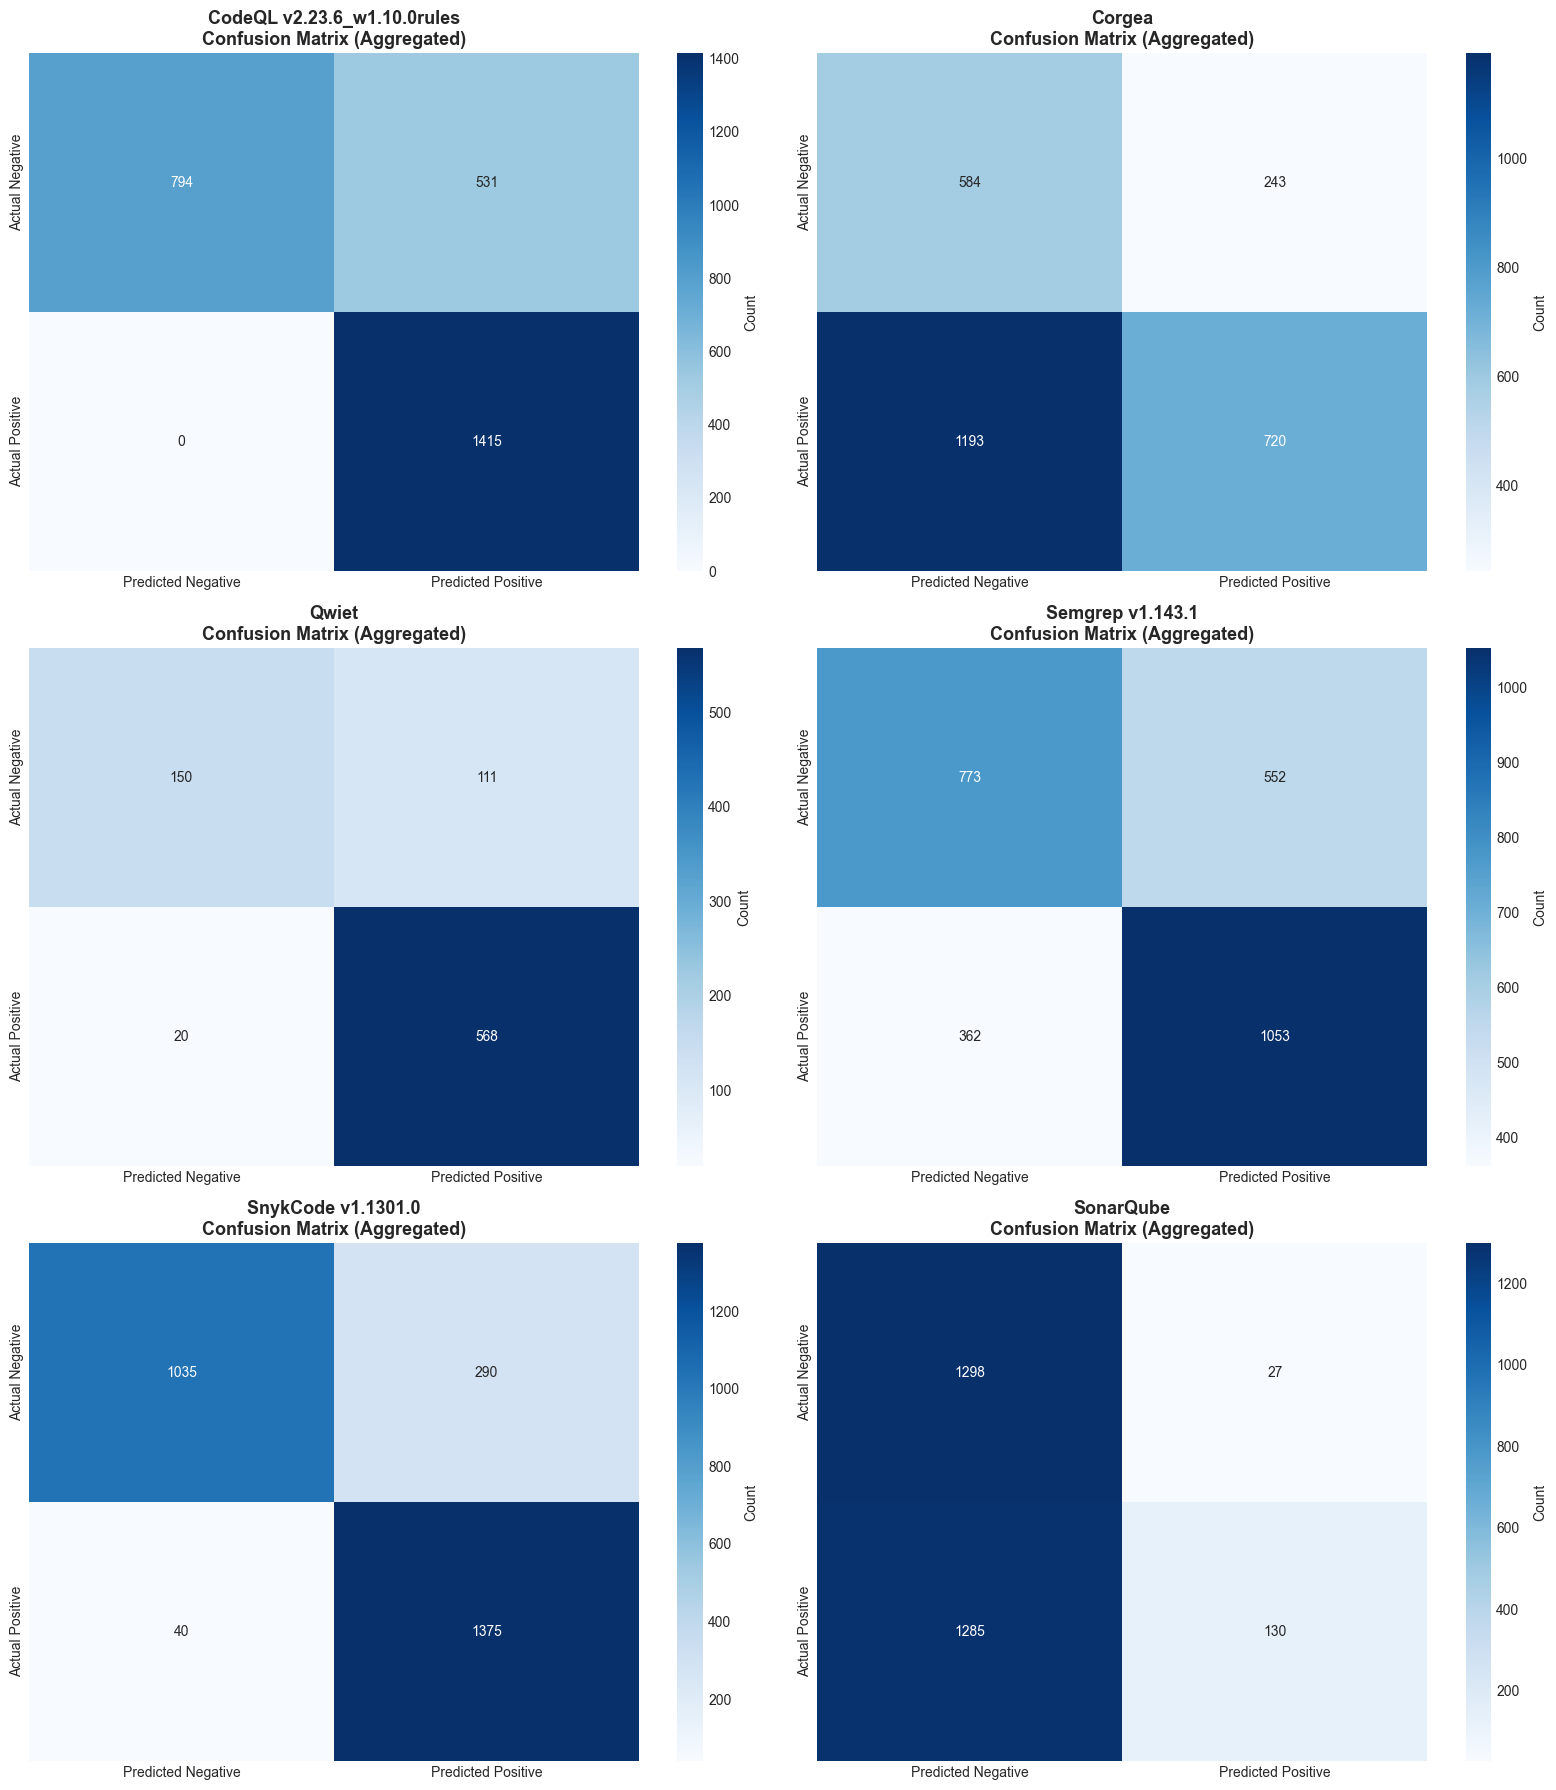

In [22]:
if 'df_tools' in locals():
    # aggregate confusion matrix values by tool
    confusion_agg = df_tools.groupby('Tool')[['TP', 'FP', 'TN', 'FN']].sum()
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()
    
    tools = confusion_agg.index
    
    for idx, tool in enumerate(tools):
        if idx < 6:
            values = confusion_agg.loc[tool]
            
            cm = np.array([[values['TN'], values['FP']],
                          [values['FN'], values['TP']]])
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['Predicted Negative', 'Predicted Positive'],
                       yticklabels=['Actual Negative', 'Actual Positive'],
                       cbar_kws={'label': 'Count'})
            
            axes[idx].set_title(f'{tool}\nConfusion Matrix (Aggregated)', 
                              fontsize=13, fontweight='bold')
    
    # hide unused subplots if less than 4 tools
    for idx in range(len(tools), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## Export Summary

In [23]:
# if 'df_tools' in locals():
#     # export complete dataset
#     df_tools.to_csv(os.path.join(to_save,'summary.csv'), index=False)
    
#     # Export pivot tables
#     pivot_tpr.to_csv(os.path.join(to_save,'tpr_by_tool_and_vulnerability.csv'))
#     pivot_fpr.to_csv(os.path.join(to_save,'fpr_by_tool_and_vulnerability.csv'))
#     pivot_score.to_csv(os.path.join(to_save,'score_by_tool_and_vulnerability.csv'))
    
#     # Export summary statistics
#     summary_stats.to_csv(os.path.join(to_save,'summary_statistics.csv'))
    
#     if 'df_summary' in locals() and df_summary is not None:
#         df_summary.to_csv(os.path.join(to_save,'overall_tool_scores.csv'), index=False)